In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from src.data_tools.get_data import get_data

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.plotting_tools.draw_stack_plot_hists import draw_bckground, draw_signals, draw_data, draw_stackplot
from src.plotting_tools.SysHist import SysHist, rebin_np
from src.plotting_tools.Bins import Bins, bins
from src.plotting_tools.utils import ratio_plot_template

In [5]:
split_bins = bins

In [6]:
from src.general.array_utils import moving_average, moving_sum, super_sample, super_sample_function, moving_avg_func, unp_array_to_nom_std
from src.plotting_tools.cms_format import cms_style, cms_format_fig

In [7]:
cms_style()

In [8]:
output_dir = 'assets_feb_23'
outdir = '{}/abcd'.format(output_dir)

In [9]:
era = '2016'
#mdf, lumi = get_data(era, output_dir, df_filter=lambda x: x.type.str.contains('bck'), stitch_dy=1)

In [10]:
plot_df = pd.read_pickle('{}/data/combined_{}_flat_hist.pkl'.format(output_dir, era))

In [31]:
hist = SysHist.from_dict(plot_df.iloc[20].to_dict())

In [200]:
from src.plotting_tools.colors import color_fader
from src.assets.file_groups import bck_dict, bck_list, bck_colors
import numpy as np

def is_equal(x,y):
    if type(x)!=type(y): return False
    return x==y

class stack_plotter():
    def __init__(self, plot_df, era, rebin=0, x_range=(-np.inf, np.inf)):
        self.plot_df = plot_df
        self.era = era
        self.rebin = rebin
        self.x_range = x_range
    def make_hist(self, row):
        sh = SysHist.from_dict(row)
        if not is_equal(self.rebin, 0): sh = sh.rebin(self.rebin)
        sh = sh.reduce_range(bottom=self.x_range[0], top=self.x_range[1])
        # ST isr fsr issue
        if row.sample_name in ['mc_santitop','mc_stop']:
            sh.sys['Weight_ISRFSR_Up'] = [sh.sys['Weight_ISRFSR_Up'][0]*0, sh.sys['Weight_ISRFSR_Up'][0]*0]
        if sh.sys != {}: sh.sys_from_sys_dict()
        return sh 
    
    def feature_reg_df(self, feature, reg):
        return self.plot_df[(self.plot_df.reg==reg) & (self.plot_df.feature==feature) & (self.plot_df.era==int(self.era))]
    def bck_df(self, feature, reg):
        tdf = self.feature_reg_df(feature, reg)
        return tdf[tdf.type=="bck"]
    def combine_hists(self, df):
        nhists = 0
        for i, row in df.iterrows():
            if not nhists:
                chist = self.make_hist(row)
            else: chist += self.make_hist(row)
            nhists += 1
        return chist
    def combine_back(self, feature, reg):
        bdf = self.bck_df(feature, reg)
        return self.combine_hists(bdf)     
    def draw_background(self, ax, feature, reg, ratio = -1, draw_sys=1,  error_scale=1, make_density=1, scale = 1, **kwargs):
        bdf = self.bck_df(feature, reg)
        hist_dict = {}
        nhists = 0
        _nominal_values = []
        for cat in bck_dict:
            _name_list = bck_dict[cat]
            _name_tdf = bdf[bdf.sample_name.isin(_name_list)]
            _chist = self.combine_hists(_name_tdf)
            if make_density: _chist = _chist.make_density_hist()
            _nominal_values.append(_chist.nominal) 
        ax.stackplot(_chist.calc_bin_centers(), _nominal_values,
                     labels=[x for x in bck_dict], alpha=1, step='mid', colors=bck_colors)
        bhist = self.combine_back(feature, reg)
        if make_density: bhist = bhist.make_density_hist()
        bhist.draw(ax, color='gray', alpha=.5, draw_sys=draw_sys, error_scale=error_scale)
        return bhist
    def draw_signals(self, ax, feature, reg,
                     dbs_values = [0.04], mass_values = [125., 150., 175., 200., 250, 300, 350.],
                    c1='#ff2f00', c2='#0486ff',
                    ratio=-1,  draw_sys=1, make_density=1, **kwargs):
        nmass = len(mass_values)
        colors = [color_fader(c1,c2,mix=(i+.0)/nmass) for i in range(nmass)]
        
        tdf = self.feature_reg_df(feature, reg)
        sdf =  tdf[tdf.type=='sig']
        for dbs in dbs_values:
            for color, mass in zip(colors, mass_values): 
                _sdf = sdf[(sdf.mass==mass) & (sdf.dbs==dbs)]
                _shist = self.make_hist(_sdf.iloc[0])
                if make_density: _shist = _shist.make_density_hist()
                _shist.draw(ax, color=color, label='{} GeV'.format(int(mass)), draw_sys=draw_sys)
    def draw_data(self, ax, feature, reg, return_hist=0, make_density=1, **kwargs):
        mu_regions = ['SR1', 'SR2', 'CR10', 'CR20']
        tdf = self.feature_reg_df(feature, reg)
        data_string = '_ele.csv'
        if reg in mu_regions: data_string = '_mu.csv'
        ddf = tdf[(tdf.type=='data') & (tdf.file.str.contains(data_string))]
        _dhist = self.combine_hists(ddf)
        if make_density: _dhist = _dhist.make_density_hist()
        ax.errorbar(_dhist.calc_bin_centers(), _dhist.nominal, yerr=_dhist.std, color='black', label='data',
           ls='', marker='o')
        if return_hist: return _dhist
        return _dhist.nominal.sum()

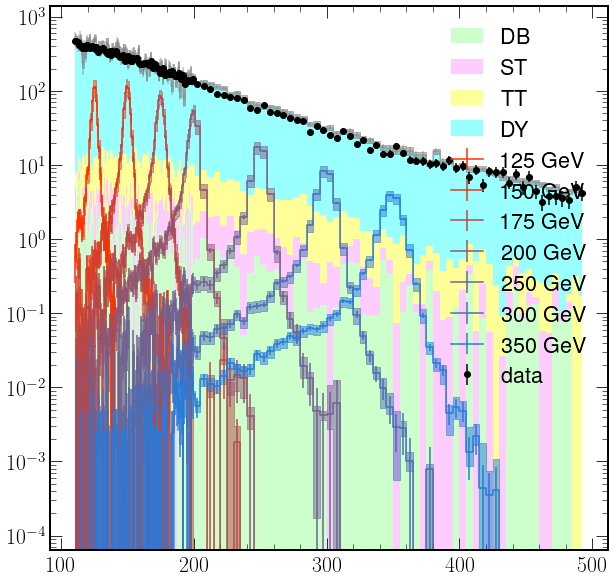

In [202]:
sp = stack_plotter(plot_df, era, rebin=split_bins.bin_edges, x_range=[100,500])
fig, ax = plt.subplots(1)
sp.draw_background(ax, 'DiLepMass', 'CR10', make_density=1)
sp.draw_signals(ax, 'DiLepMass', 'CR10', make_density=1)
sp.draw_data(ax, 'DiLepMass', 'CR10', make_density=1)
ax.legend()
ax.set_yscale('log')

In [15]:
#sel = mdf.name.str.contains('DYJetsToLL')
#mdf.loc[sel, 'Weight_PDF_ISRFSR_Up'] = mdf.loc[sel, 'Weight']*1.16
#mdf.loc[sel, 'Weight_PDF_ISRFSR_Down'] = mdf.loc[sel, 'Weight']*(1-.16)

In [16]:
mdf.type.unique()

NameError: name 'mdf' is not defined

In [ ]:
bins_red = Bins(np.linspace(105,900, int((900-105)/5+1)))
bins_red = Bins(np.linspace(105,900, 300))

bins_red

In [ ]:
mc_hists = {}
for reg in ['CR14','CR24', 'CR10','CR20', 'CR13', 'CR23']:
    fig, ax = plt.subplots(1)
    mc_hists[reg] = draw_data(ax, mdf, 'DiLepMass', reg, era, bin_edges=bins_red.bin_edges, return_hist=1, make_density=0)
    ax.set_yscale('log')

In [ ]:
mc_hists_other_binning = {}
for reg in ['CR14','CR24', 'CR10','CR20', 'CR13', 'CR23']:
    fig, ax = plt.subplots(1)
    mc_hists_other_binning[reg] = draw_data(ax, mdf, 'DiLepMass', reg, era, bin_edges=bins.bin_edges, return_hist=1)
    ax.set_yscale('log')

In [ ]:
def open_and_convert_plotting_dict(fn):
    with open(fn, 'rb') as f:
        plot_dict= pickle.load(f)
        
    for reg in plot_dict:
        if 'hist' in plot_dict[reg]:
            plot_dict[reg]['hist'] = SysHist.from_dict(plot_dict[reg]['hist'])
        plot_dict[reg]['fit'] = SysHist.from_dict(plot_dict[reg]['fit'])
    return plot_dict

In [ ]:
def compare_hists(hist1, hist2, ismc = False, n=10, ndof=0, log=1, color='red', label1="", label2="", isdata=0, **kwargs):
    fig, ax, rax = ratio_plot_template(figsize=(10,10))
    hist1.draw(ax, label=label1, zorder=3)
    if isdata:
        ax.errorbar(hist2.calc_bin_centers(), hist2.nominal, yerr=hist2.std, color='black', label=label2,
           ls='', marker='o', zorder=1)
    else:
        hist2.draw(ax, label=label2, color=color)
    
    x = hist1.calc_bin_centers()

    rax.plot(x, np.full(len(x), 1) , color='black', linestyle=':')
    rax.plot(x, np.full(len(x), 0) , color='black')
    rax.plot(x, np.full(len(x), -1) , color='black', linestyle=':')
    
    cms_format_fig(era, ax)
    if log:
        ax.set_yscale('Log')
    ax.set_ylabel('Counts per GeV')
    rax.set_xlabel('DiLepMass [GeV]')
    rax.set_ylim(-5,5)
    rax.set_ylabel('Pull')
    
    nom1_avg = moving_sum(hist1.nominal, n = n)
    nom2_avg = moving_sum(hist2.nominal, n = n)
    var1_avg = moving_sum(hist1.std**2, n = n)
    var2_avg = moving_sum(hist2.std**2, n = n)
    x_avg = moving_average(x, n=n)
    if ismc:
        pull = (nom1_avg-nom2_avg)/(var2_avg+var1_avg)**.5
    else:
        pull = (nom1_avg-nom2_avg)/nom1_avg**.5
    pullsquare = pull**2
    
    rax.plot(x_avg, pull)
    
    return  {'chi2': (pullsquare).sum()/(hist1.calc_nBins()-ndof),
             'fig': fig,
             'ax': ax,
             'rax': rax}
    

In [ ]:
from scipy.optimize import curve_fit
from src.general.functions import power_func, power_law, make_bpoly, linear, parabola, make_bpoly_exp

In [ ]:
from scipy.optimize import curve_fit
from src.general.functions import make_bpoly, lognorm, log_norm_np, log_norm_unp
from src.plotting_tools.SysHist import SysHist

In [ ]:
import uncertainties
import uncertainties.unumpy as unp

In [ ]:
def fit_hist(func, hist, n=10, comp_hist_n =10, do_super_sample=1, ismc=False,  do_unc=1, color='red', label1="", label2="", isdata=0, **kwargs):
    x = np.array(hist.calc_bin_centers())
    popt, pcov = curve_fit(func, x, hist.nominal, 
                       **kwargs,
                       sigma=hist.std, maxfev = int(1e6))  

    if do_unc:
        #create fit values with uncertainties
        popt_unc = uncertainties.correlated_values(popt, pcov)
        #make_fit_hist
        y = log_norm_unp(x, *popt_unc)
        y_nom, y_std = unp_array_to_nom_std(y)
    else: 
        y_nom = func(x, *popt)
        varper = ((hist.nominal-y_nom)**2/y_nom).mean()
        y_std = (varper*y_nom)**.5
        y_std = y_nom**.5
    fit_hist = SysHist(
            y_nom,
            x*0, x*0, 
            y_std,
            np.array(hist.bin_edges)
        ).normalize().calc_ratio(1/hist.calc_sum())
    
    #bins from analysis
    x_other = np.array(bins_other_binning.calc_bin_centers())
    y_nom = func(x_other, *popt)
    y_std = y_nom*.1   
    if do_unc:
        popt_unc = uncertainties.correlated_values(popt, pcov)
        y = log_norm_unp(x_other, *popt_unc)
        _, y_std = unp_array_to_nom_std(y)
    fit_hist_other_binning = SysHist(
            y_nom,
            x_other*0, x_other*0, 
            y_std,
            np.array(bins_other_binning.bin_edges)
        ).reduce_range(bottom=bottom_value, top=1000).inverse_make_density_hist().normalize().calc_ratio(1/hist.calc_sum())
    
        #)#.reduce_range(bottom=bottom_value, top=top_value).inverse_make_density_hist().normalize().calc_ratio(1/hist.calc_sum())

    compare_dict = compare_hists(fit_hist, hist, ismc=ismc, n=comp_hist_n, color = color, ndof=5, label1=label1, label2=label2, isdata=isdata)
    return {**compare_dict, 
            "popt" : popt,
            "fit_hist": fit_hist,
            "fit_hist_other_binning": fit_hist_other_binning
           }

In [ ]:
bottom_value = 120
top_value=400

In [ ]:
comp_hist_n = 1
fit_dict = {}
ismc=1
for reg in ['CR14','CR24', 'CR10','CR20', 'CR13', 'CR23']:
    _plot_dict = mc_hists[reg]

    hist = mc_hists[reg].reduce_range(bottom=bottom_value, top=top_value)
    hist.up *=0
    hist.down *=0

    total_events = hist.nominal.sum()
    curve_fit_chi2 = fit_hist(log_norm_np, hist, comp_hist_n=comp_hist_n, do_super_sample=0, 
                              ismc=True, p0=[total_events*10, .8, 80, 70], 
                              bounds = ([0, .2, 50, 50], [total_events*100, 1, 100, 100]),
                              do_unc=1, label1='fit', label2='MC', isdata=0,
                             )
    
    
    draw_bckground(curve_fit_chi2['ax'], mdf, 'DiLepMass', reg, era, bin_edges=hist.bin_edges, make_density=0)
    fit_dict[reg] = curve_fit_chi2
    print(reg, curve_fit_chi2['chi2'],  repr(curve_fit_chi2['popt']))
    curve_fit_chi2['ax'].legend(ncol=2)
    curve_fit_chi2['fig'].savefig('{}/mc_fit_era{}_ismc{}_reg{}_bottom{}_lognorm.pdf'.format(outdir,era,ismc,reg,bottom_value))
    #curve_fit_chi2['fig'].savefig('fits/curve_fit_closure_test_22/mc_fit_era{}_ismc{}_reg{}_bottom{}_lognorm.pdf'.format(era,ismc,reg,bottom_value))

In [ ]:
real_mc_hists_other_binning = {}
for reg in ['SR1', 'SR2']:
    fig, ax = plt.subplots(1)
    real_mc_hists_other_binning[reg] = draw_bckground(ax, mdf, 'DiLepMass', reg, era, bin_edges=bins.bin_edges, make_density=0)
    ax.set_yscale('log')

In [ ]:
for nJets in [1,2]:
    reg = 'SR{}'.format(nJets)
    A = fit_dict['CR{}0'.format(nJets)]['fit_hist_other_binning'].reduce_range(bottom=bottom_value, top=1000)
    B = fit_dict['CR{}3'.format(nJets)]['fit_hist_other_binning'].reduce_range(bottom=bottom_value, top=1000)
    C = fit_dict['CR{}4'.format(nJets)]['fit_hist_other_binning'].reduce_range(bottom=bottom_value, top=1000)
    print(A.calc_sum(), B.calc_sum(), C.calc_sum(), ( A.uncertainty_std_dev()*B.uncertainty_std_dev()/C.uncertainty_std_dev()).sum() )
    abcd = A.uncertainty_std_dev()*B.uncertainty_std_dev()/C.uncertainty_std_dev()
    abcd_nom, abcd_std = unp_array_to_nom_std(abcd)
    #abcd_std = abcd_nom**.5
    
    hist =  real_mc_hists_other_binning['SR{}'.format(nJets)].reduce_range(bottom=bottom_value, top=1000).make_density_hist()
    hist.up *=0
    hist.down *=0
    
    #abcd_hist = SysHist(abcd_nom, abcd_nom*0,abcd_nom*0,abcd_std, hist.bin_edges)#.reduce_range(bottom=bottom_value, top=top_value).make_density_hist()
    abcd_hist = SysHist(abcd_nom, abcd_nom*0,abcd_nom*0,abcd_std, hist.bin_edges).make_density_hist()
    print(hist.inverse_make_density_hist().calc_sum(), abcd_hist.inverse_make_density_hist().calc_sum())
    #reduce the range to the area used for chi2
    compare_hist_dict = compare_hists(abcd_hist.reduce_range(bottom=bottom_value, top=top_value), 
                                      hist.reduce_range(bottom=bottom_value, top=top_value), 
                                      ismc=True, n=1, log=True, color='black', label1='ABCD pred.', label2='MC',  isdata=0)
    
    #draw stack plot background
    draw_bckground(compare_hist_dict['ax'], mdf, 'DiLepMass', reg, era, 
                   bin_edges=abcd_hist.reduce_range(bottom=bottom_value, top=top_value).bin_edges, make_density=1)
    
    compare_hist_dict['ax'].legend(ncol=2)
    
    #compare_hist_dict['fig'].savefig('fits/curve_fit_closure_test_22/abcd_era{}_ismc{}_regSR{}_bottom{}_lognorm_splt_binning.pdf'.format(era,ismc,nJets,bottom_value))
    compare_hist_dict['fig'].savefig('{}/mc_abcd_era{}_ismc{}_regSR{}_bottom{}_lognorm_splt_binning.pdf'.format(outdir,era,ismc,nJets,bottom_value))
    compare_hist_dict['fig'].show()
    
    compare_hist_dict['ax'].set_xlim(120,200)
    compare_hist_dict['rax'].set_xlim(120,200)
    compare_hist_dict['ax'].set_ylim(bottom=0.001, top=150)
    compare_hist_dict['ax'].set_yscale('linear')
    compare_hist_dict['fig'].savefig('{}/mc_abcd_era{}_ismc{}_regSR{}_bottom{}_lognorm_splt_binning_200GeV_max.pdf'.format(outdir,era,ismc,nJets,bottom_value))

    fit_dict['SR{}'.format(nJets)]= compare_hist_dict
    fit_dict['SR{}'.format(nJets)]['fit_hist'] = abcd_hist
    

In [ ]:
for nJets in [1,2]:
    reg = 'SR{}'.format(nJets)
    A = fit_dict['CR{}0'.format(nJets)]['fit_hist_other_binning'].reduce_range(bottom=bottom_value, top=1000)
    B = fit_dict['CR{}3'.format(nJets)]['fit_hist_other_binning'].reduce_range(bottom=bottom_value, top=1000)
    C = fit_dict['CR{}4'.format(nJets)]['fit_hist_other_binning'].reduce_range(bottom=bottom_value, top=1000)
    print(A.calc_sum(), B.calc_sum(), C.calc_sum(), ( A.uncertainty_std_dev()*B.uncertainty_std_dev()/C.uncertainty_std_dev()).sum() )
    abcd = A.uncertainty_std_dev()*B.uncertainty_std_dev()/C.uncertainty_std_dev()
    abcd_nom, abcd_std = unp_array_to_nom_std(abcd)
    #abcd_std = abcd_nom**.5
    
    hist =  real_mc_hists_other_binning['SR{}'.format(nJets)].reduce_range(bottom=bottom_value, top=1000).make_density_hist()
    hist.up *=0
    hist.down *=0
    
    #abcd_hist = SysHist(abcd_nom, abcd_nom*0,abcd_nom*0,abcd_std, hist.bin_edges)#.reduce_range(bottom=bottom_value, top=top_value).make_density_hist()
    abcd_hist = SysHist(abcd_nom, abcd_nom*0,abcd_nom*0,abcd_std, hist.bin_edges).make_density_hist()
    print(hist.inverse_make_density_hist().calc_sum(), abcd_hist.inverse_make_density_hist().calc_sum())
    #reduce the range to the area used for chi2
    compare_hist_dict = compare_hists(abcd_hist.reduce_range(bottom=bottom_value, top=top_value), 
                                      hist.reduce_range(bottom=bottom_value, top=top_value), 
                                      ismc=True, n=1, log=True, color='black', label1='ABCD pred.', label2='MC',  isdata=0)
    
    #draw stack plot background
    draw_bckground(compare_hist_dict['ax'], mdf, 'DiLepMass', reg, era, 
                   bin_edges=abcd_hist.reduce_range(bottom=bottom_value, top=top_value).bin_edges, make_density=1)
    
    compare_hist_dict['ax'].legend(ncol=2)
    
    #compare_hist_dict['fig'].savefig('fits/curve_fit_closure_test_22/abcd_era{}_ismc{}_regSR{}_bottom{}_lognorm_splt_binning.pdf'.format(era,ismc,nJets,bottom_value))
    compare_hist_dict['fig'].savefig('{}/mc_abcd_era{}_ismc{}_regSR{}_bottom{}_lognorm_splt_binning.pdf'.format(outdir,era,ismc,nJets,bottom_value))
    compare_hist_dict['fig'].show()
    
    compare_hist_dict['ax'].set_xlim(120,200)
    compare_hist_dict['rax'].set_xlim(120,200)
    compare_hist_dict['ax'].set_ylim(bottom=0.001, top=150)
    compare_hist_dict['ax'].set_yscale('linear')
    compare_hist_dict['fig'].savefig('{}/mc_abcd_era{}_ismc{}_regSR{}_bottom{}_lognorm_splt_binning_200GeV_max.pdf'.format(outdir,era,ismc,nJets,bottom_value))

    fit_dict['SR{}'.format(nJets)]= compare_hist_dict
    fit_dict['SR{}'.format(nJets)]['fit_hist'] = abcd_hist
    

In [ ]:
{reg: item['chi2'] for reg, item in fit_dict.items()}

In [ ]:
fit_list = []
for reg, item in fit_dict.items():
    try:
        _plot_dict = mc_hists[reg].reduce_range(bottom=bottom_value, top=top_value)
    except:
        _plot_dict = real_mc_hists_other_binning[reg].reduce_range(bottom=bottom_value, top=top_value)
    _fit_dict = {
        "era": era,
        "region": reg,
    'n_{background}': "{:.2f}".format(_plot_dict.uncertainty_std_dev().sum()),
    'n_{ABCD,Data}': "{:.2f}".format(item['fit_hist'].inverse_make_density_hist().uncertainty_std_dev().sum()),
    ' Data $\chi^2/n_{DOF}$': "{:.2f}".format(item['chi2'])
    }
    fit_list.append(_fit_dict)

In [ ]:
with open('{}/fit_stats_mc_{}.txt'.format(outdir,era), 'w') as f:
    latex = pd.DataFrame(fit_list).to_latex()
    print(latex)
    f.write(latex)

In [ ]:
#format dict for saving
limit_dict = {}
for reg, item in fit_dict.items():
    limit_dict[reg] = item['fit_hist'].to_dict()

In [ ]:
import pickle as pkl
with open('{}/abcd_dict_mc_{}.pkl'.format(outdir, era), 'wb') as f:
    pkl.dump(limit_dict, f)